# Operator learning kernel methods for 1 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict
import os

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth
LWTHIN = 0.025

## Reference Solution

We will randomly generate $v$ from 
$$\exp\left(-\frac{1}{1-r^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$. 

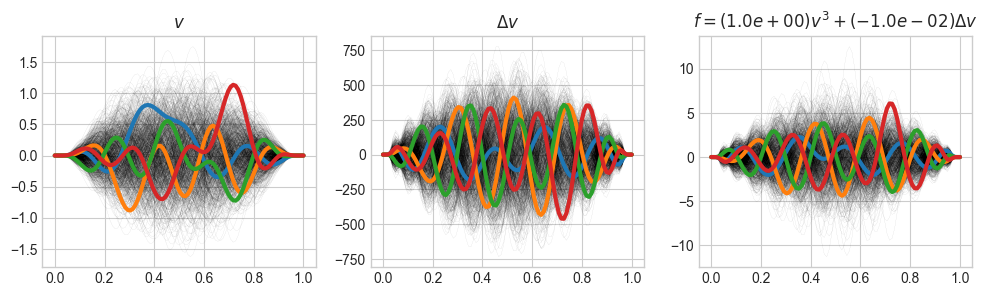

In [3]:
C1 = 1.
C2 = -1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**10
P = 10
B_low = -1.
B_high = 1.
a = torch.from_numpy(qp.Uniform(qp.DigitalNetB2(P,seed=7,graycode=True),lower_bound=B_low,upper_bound=B_high).gen_samples(R))
xticks = torch.linspace(0,1,100,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
coloridxs = torch.arange(4)
ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
ax[0].set_title(r"$v$")
ax[1].set_title(r"$\Delta v$")
ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## PDE setup

In [4]:
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v 
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v 
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

## Kernel interpolant setup

In [5]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(xs,kernel,llbetas,llcs,noise) # kernel interpolant

## Dataset Generation

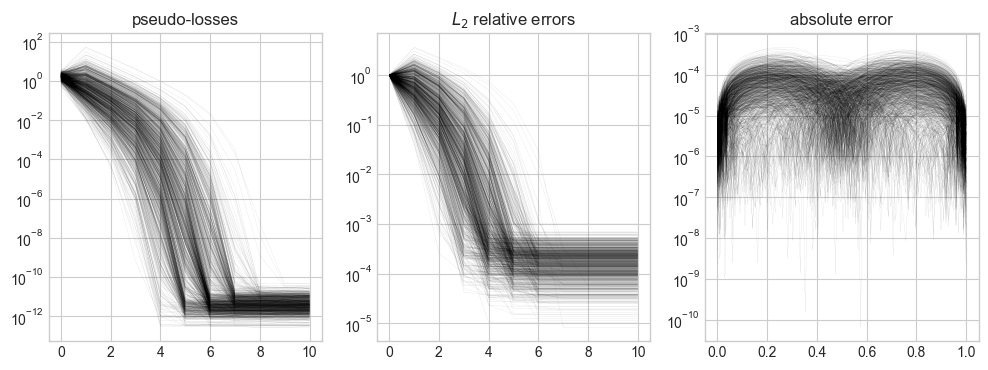

In [10]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "./%s.%s.pt"%("oplearn_elliptic_pde_1d",tag)
    if os.path.exists(fname) and not force_gen:
        data = torch.load(fname)
        vopt = data["vopt"]
        losses_opt = data["losses_opt"]
        vhats = data["vhats"]
        l2rerrs = data["l2rerrs"]
    else:
        vopt = torch.empty((R,maxiter+1,ki.length),dtype=float)
        losses_opt = torch.empty((R,maxiter+1),dtype=float)
        vhats = torch.empty((R,maxiter+1,len(xticks)),dtype=float)
        l2rerrs = torch.empty((R,maxiter+1),dtype=float)
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//8
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                u_i,u_laplace_i = ly_i
                u_b = ly_b[0] 
                lhs_i = C1*u_i**3+C2*u_laplace_i
                lhs_b = u_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,losses_opt[r,:],rerrors_opt,times_opt,vopt[r,:,:] = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                solver = "CHOL",
                verbose = False)
            coeffs = ki._solve(vopt[r,:,:].T)
            vhats[r,:,:] = (kvec@coeffs).T
            l2rerrs[r,:] = torch.linalg.norm(vhats[r,:,:]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])
            if (r+1)%verbosity==0:
                with np.printoptions(precision=1,threshold=8):
                    print(l2rerrs[r,:].numpy())
            data = {
                "vopt": vopt,
                "losses_opt": losses_opt,
                "vhats": vhats,
                "l2rerrs": l2rerrs,}
        torch.save(data,fname)
    return vopt,losses_opt,vhats,l2rerrs
vopt,losses_opt,vhats,l2rerrs = get_data(maxiter=10,tag="full",force_gen=False)
best_idxs = losses_opt.argmin(1)
vhats_best = vhats[np.arange(R),best_idxs,:]
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
ax[0].set_title("pseudo-losses")
ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
ax[1].set_yscale("log",base=10)
ax[2].set_title("absolute error")
ax[2].plot(xticks,torch.abs(vhats_best-vticks).T,color="k",linewidth=LWTHIN)
ax[2].set_yscale("log",base=10);

## DeepONet modeling

In [11]:
uticks.shape,vopt.shape

(torch.Size([1024, 100]), torch.Size([1024, 11, 202]))